# Learning a macroscale PDE with a Neural Network 

In [28]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from scipy.interpolate import interp1d as interp1d
from matplotlib import cm
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
import time

In [2]:
seed0 = 8 #6
tf.keras.utils.set_random_seed(seed0) 
tf.config.experimental.enable_op_determinism()

### Importing Data and pre-processing

Importing: x, t, b, bx, bxx, c, cx, cxx, bt, ct

x = 0.5:0.5:1000    (2000 points in space)  
t = 200:0.1:300   (1001  profiles)

In [3]:
b_0 = np.loadtxt('Data/b.txt')[1:,1:]
bt_0 = np.loadtxt('Data/bt.txt')[1:,1:]
bx_0 = np.loadtxt('Data/bx.txt')[1:,1:]
bxx_0 = np.loadtxt('Data/bxx.txt')[1:,1:]
c_0 = np.loadtxt('Data/c.txt')[1:,1:]
ct_0 = np.loadtxt('Data/ct.txt')[1:,1:]
cx_0 = np.loadtxt('Data/cx.txt')[1:,1:]
cxx_0 = np.loadtxt('Data/cxx.txt')[1:,1:]
r_ar_0 = np.loadtxt('Data/x.txt')[1:,0]
t_ar_0 = np.loadtxt('Data/t.txt')[0,1:]


NR0 = r_ar_0.shape[0]
NT0 = t_ar_0.shape[0]

In [ ]:
laplb = np.zeros(b_0.shape)
laplc = np.zeros(c_0.shape)

for i in range(NT0):
    laplb[:,i] = bxx_0[:,i] + bx_0[:,i]/r_ar_0
    laplc[:,i] = cxx_0[:,i] + cx_0[:,i]/r_ar_0

rhs_0 = np.concatenate(([b_0.T], [bx_0.T], [laplb.T], [c_0.T], [cx_0.T], [laplc.T]), axis=0)

In [39]:
rhs_0.shape

(6, 1001, 2000)

In [5]:
rmin, rmax = 1, 500
tmin, tmax = 0, -700
Nr=1
Nt=10

r_ar_1=r_ar_0[rmin:rmax:Nr]
t_ar_1=t_ar_0[tmin:tmax:Nt]

NR1, NT1=r_ar_1.shape[0], t_ar_1.shape[0]

In [6]:
bt_1 = bt_0.T[tmin:tmax:Nt, rmin:rmax:Nr]
ct_1 = ct_0.T[tmin:tmax:Nt, rmin:rmax:Nr]

rhs_1 = rhs_0[:,tmin:tmax:Nt, rmin:rmax:Nr]

### Boundary Conditions

In [7]:
leftbc_b= interp1d(t_ar_0, rhs_0[0,:,rmin-1], kind='linear')
rightbc_b= interp1d(t_ar_0, rhs_0[0,:,rmax], kind='linear')

leftbc_c= interp1d(t_ar_0, rhs_0[3,:,rmin-1], kind='linear')
rightbc_c= interp1d(t_ar_0, rhs_0[3,:,rmax], kind='quadratic')

In [8]:
cp_bt=np.hstack((np.ravel(bt_1)))

cp_rhs= np.reshape(rhs_1, (6, NT1*NR1)).T

In [43]:
cp_rhs.shape

(15469, 6)

In [44]:
cp_bt.shape

(15469,)

### Normalization

In [9]:
Norm_in=np.copy(cp_rhs)

Norm_in_mu = np.mean(Norm_in, axis=0) #np.zeros(6)

Norm_in_si = np.std(Norm_in, axis=0, ddof=1) #np.ones(6)

for i in range(6):
    Norm_in[:,i]=(cp_rhs[:,i]-Norm_in_mu[i])/Norm_in_si[i]
    
    
Norm_out=np.copy(cp_bt)

Norm_out_mu=np.mean(Norm_out)

Norm_out_si=np.std(Norm_out, ddof=1)

Norm_out=(cp_bt-Norm_out_mu)/Norm_out_si

In [10]:
input_data=Norm_in
target_data=Norm_out

# Black Box

### NN Training

In [11]:
np.random.seed(seed0)

INP_train, INP_test, BT_train, BT_test = train_test_split(input_data ,target_data, train_size=7/8)

In [12]:
def predict_u_net(n_input: int,
                  n_units: int=32):
    
    
    """ A feed-forward model for predicting u from some observables.
    
    Args:
        n_input: number of observables (e.g. pointwise measurements) + 1 (bc x value)
        n_units: number of units within each dense layer

    Returns:
        tf.keras.model that maps observables to u,u_x,... at x
    """

    u=tf.keras.Input(shape=(n_input,),name="observables_and_x")

    dlayer1 = Dense(n_units,activation='tanh',name='dense_1')
    u1 = dlayer1(u)
    
    dlayer2 = Dense(n_units,activation='tanh',name='dense_2')
    u2 = dlayer2(u1)
    
    dlayer3 = Dense(1,activation='linear',name='dense_3')
    u3 = dlayer3(u2)
    
    return tf.keras.Model(u,u3)


uder_model= predict_u_net(6,25)
uder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ observables_and_x (InputLayer)  │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │           175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851 (3.32 KB)

 Trainable params: 851 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# compile the model
adamsky=tf.keras.optimizers.Adam(learning_rate=0.001) #0.0005
uder_model.compile(optimizer=adamsky,loss='mse')
batch_size=  int(15469/1) #30000
epochs = 256*15

In [14]:
time_t1 = time.time()

train_history=uder_model.fit(INP_train,BT_train,
        batch_size=batch_size,epochs=epochs,
        verbose=0,validation_split=.05)

time_t2 = time.time()

In [15]:
'Training time: ', time_t2-time_t1, 31.435433864593506

('Training time: ', 350.2988750934601, 31.435433864593506)

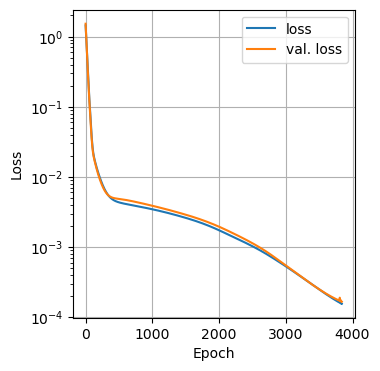

In [33]:
# traiining history
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(train_history.history['loss'],label='loss')
plt.plot(train_history.history['val_loss'],label='val. loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [29]:
eval_loss_raw0 = uder_model.evaluate(INP_test, BT_test, batch_size=INP_test.shape[0],verbose=0)
eval_loss0 = eval_loss_raw0/np.std(BT_test, ddof=1)
print('Relative Test Loss:', eval_loss0)
print ('Test Loss:', eval_loss_raw0)
print('Training Loss: ',train_history.history['loss'][-1])
print('Validation Loss: ', train_history.history['val_loss'][-1])

Relative Test Loss: 0.00013448697719420287
Test Loss: 0.00013395118003245443
Training Loss:  0.00015519149019382894
Validation Loss:  0.0001660888228798285


### NN Postprocessing - PDE Definition

Features: b, bx, bxx, c, cx, cxx  


In [ ]:
def b_to_input_vec(b, c, t, r_array):
    
    dx=0.5
    
    Resx=b.shape[0]

    ders=np.zeros([Resx, 6])
    ders2=np.zeros([Resx, 6])
    
    ders[:,0]=b    
    
    ders[1:-1,1]=(b[2:]-b[:-2])/dx/2
    ders[0,1]=(b[1]-leftbc_b(t))/dx/2
    ders[-1,1]=0
    
    ders[1:-1,2]=(b[2:]-2*b[1:-1]+b[:-2])/dx**2
    ders[0,2]= (b[1]-2*b[0]+leftbc_b(t))/dx**2
    ders[-1,2]= 2*(b[-2]-b[-1])/dx**2
    
    ders[:,3]=c
    
    ders[1:-1,4]=(c[2:]-c[:-2])/dx/2
    ders[0,4]= (c[1]-leftbc_c(t))/2/dx
    ders[-1,4]= (rightbc_c(t)-c[-2])/2/dx
    
    ders[1:-1,5]=(c[2:]-2*c[1:-1]+c[:-2])/dx**2
    ders[0,5]= (c[1]-2*c[0]+leftbc_c(t))/dx**2
    ders[-1,5]= (c[-2]-2*c[-1]+rightbc_c(t))/dx**2
    
    ders1 = np.copy(ders)
    ders1[:,2]= ders[:,2]+ders[:,1]/r_array
    ders1[:,5]= ders[:,5]+ders[:,4]/r_array
    
    for i in range(6):
        ders2[:,i]=(ders1[:,i]-Norm_in_mu[i])/Norm_in_si[i]

    return ders2

def right_hand_side(t,x, r_ar_1):
    
    Nv= int(x.shape[0]/2)
    
    bt_dd=np.zeros(Nv)
    ct_dd=np.zeros(Nv)
    
    b_temp = x[:Nv]
    c_temp = x[Nv:]
        
    c_char = 1
    k = 3000
    D_c=800
        
    input_matrix=b_to_input_vec(b_temp, c_temp, t, r_ar_1)
        
        
    bt_dd = np.ravel(uder_model.predict(np.array(input_matrix),  verbose=0)*Norm_out_si+Norm_out_mu)
    
    dif_norm=input_matrix[:,5]*Norm_in_si[5]+Norm_in_mu[5]
    
    ct_dd = D_c * dif_norm - k * b_temp *  c_temp / (c_temp*10000 + c_char)

    
    return np.concatenate((bt_dd , ct_dd))

### Testing what NN learned

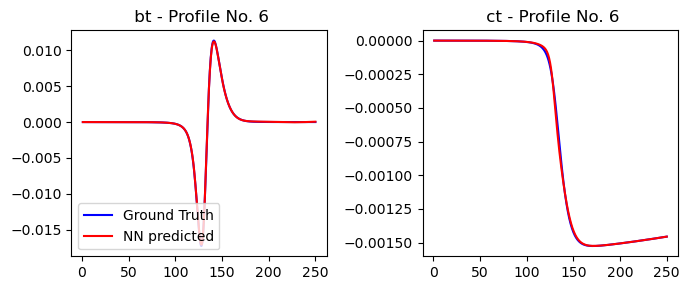

In [35]:
fig, ax=plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=[7,3])

ind1=np.random.randint(NT1)
# ind1=0
# print(NT1)

ax[0].set_title( ' bt - Profile No. '+str(ind1))
ax[1].set_title( ' ct - Profile No. '+str(ind1))

state_temp=np.concatenate((rhs_1[0,ind1,:], rhs_1[3,ind1,:] ))

ax[0].plot(r_ar_1,bt_1[ind1,:], c='blue', label='Ground Truth')
ax[0].plot(r_ar_1, right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[:NR1], c='red', label='NN predicted')
ax[1].plot(r_ar_1,ct_1[ind1,:], c='blue', label='Ground Truth')
ax[1].plot(r_ar_1, right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[NR1:], c='red', label='NN predicted')


ax[0].legend()

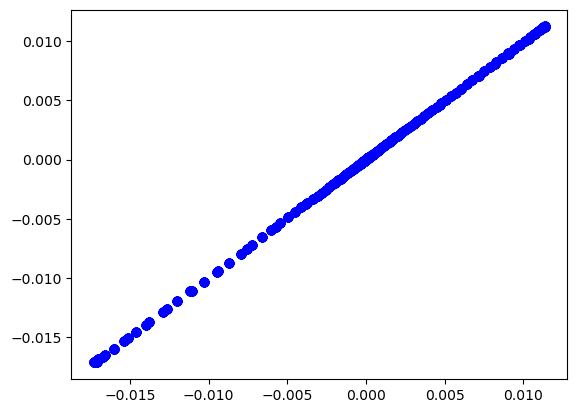

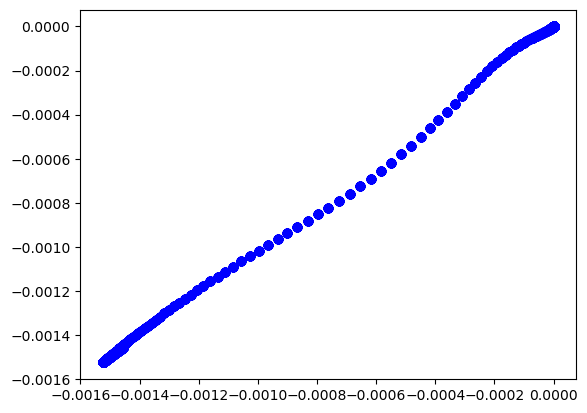

In [36]:
fig, ax = plt.subplots()
for i in range(NT1):
    ax.scatter(bt_1[ind1,:], right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[:NR1], c='b')
    
fig, ax = plt.subplots()

for i in range(NT1):
    ax.scatter(ct_1[ind1,:], right_hand_side(t_ar_1[ind1],state_temp, r_ar_1)[NR1:], c='b')

### Save the NN and Data

In [38]:
uder_model.save('BBModel.keras')

# Gray Box

In [40]:
# build a row-wise dataset with [b(t), b_x(t), lapb(t), b(t-1), b_x(t-1), lapb(t-1)]
# rows correspond to every (time t >= 1, radial position r)
b = rhs_0[0]    # shape (NT0, NR0)
bx = rhs_0[1]
lapb = rhs_0[2]

NT, NR = b.shape

# skip t=0 because it has no previous time step
b_curr = b[1: , :]      # shape (NT-1, NR)
bx_curr = bx[1: , :]
lapb_curr = lapb[1: , :]

b_prev = b[:-1, :]      # shape (NT-1, NR)
bx_prev = bx[:-1, :]
lapb_prev = lapb[:-1, :]

# flatten in time-major order so rows are (t=1,r=0),(t=1,r=1),...,(t=2,r=0),...
stack_b_bx_lapb_prev = np.empty(((NT-1)*NR, 6), dtype=b.dtype)
stack_b_bx_lapb_prev[:, 0] = b_curr.ravel(order='C')
stack_b_bx_lapb_prev[:, 1] = bx_curr.ravel(order='C')
stack_b_bx_lapb_prev[:, 2] = lapb_curr.ravel(order='C')
stack_b_bx_lapb_prev[:, 3] = b_prev.ravel(order='C')
stack_b_bx_lapb_prev[:, 4] = bx_prev.ravel(order='C')
stack_b_bx_lapb_prev[:, 5] = lapb_prev.ravel(order='C')

# optional: time and radial indices for each row
time_idx = np.repeat(np.arange(1, NT), NR)   # corresponds to the "current" time t for each row
radial_idx = np.tile(np.arange(NR), NT-1)

# results:
# - stack_b_bx_lapb_prev : array shape ((NT0-1)*NR0, 6)
# - time_idx, radial_idx : arrays giving (t,r) for each row

Epoch 1/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0446 - val_loss: 0.0015
Epoch 2/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.1964e-04 - val_loss: 2.7131e-04
Epoch 3/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.9065e-04 - val_loss: 2.1421e-04
Epoch 4/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.4367e-04 - val_loss: 2.0111e-04
Epoch 5/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.2127e-04 - val_loss: 1.7528e-04
Epoch 6/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.0499e-04 - val_loss: 1.6616e-04
Epoch 7/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.9355e-04 - val_loss: 1.4826e-04
Epoch 8/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8497e-04 - val_loss: 1.4414e-04
Epoch 9/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7803e-04 - val_loss: 1.4103e-04
Epoch 10/300
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7253e-04 - val_loss: 1.3774e-04
Epoch 11/300
1624/1624 ━━━━━━━━━━━━━━

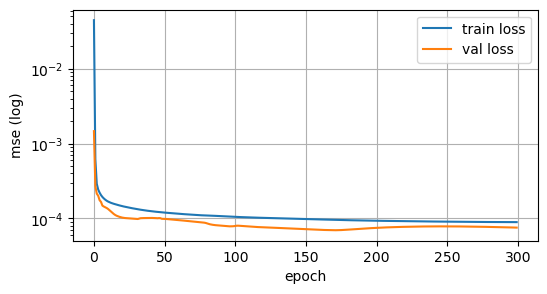

In [45]:
# Build/train a "gray-box" NN that maps [b, b_x, lapb (t), b, b_x, lapb (t-1)] -> b_t (current)
# Uses stack_b_bx_lapb_prev (rows per (t>=1,r)) and bt_0 available in the notebook.

# targets: bt at current time (t >= 1)
bt_full = bt_0.T            # shape (NT0, NR0)
y_grey = bt_full[1:, :].ravel(order='C')   # matches stack_b_bx_lapb_prev rows

X_grey = stack_b_bx_lapb_prev.copy()       # shape ((NT0-1)*NR0, 6)

# Normalize inputs and outputs (robust to zero std)
X_mu = X_grey.mean(axis=0)
X_si = X_grey.std(axis=0, ddof=1)
X_si[X_si == 0] = 1.0
Xn = (X_grey - X_mu) / X_si

y_mu = y_grey.mean()
y_si = y_grey.std(ddof=1)
if y_si == 0:
    y_si = 1.0
yn = (y_grey - y_mu) / y_si

# Train / test split
np.random.seed(seed0)
X_train, X_test, y_train, y_test = train_test_split(Xn, yn, train_size=7/8, random_state=seed0)

# Build model using the existing factory predict_u_net (input dim = 6)
grey_model = predict_u_net(n_input=6, n_units=25)
grey_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

# Train
batch_size = 1024
epochs = 300
history_grey = grey_model.fit(X_train, y_train,
                             batch_size=batch_size, epochs=epochs,
                             validation_split=0.05, verbose=1)

# Evaluate
raw_loss = grey_model.evaluate(X_test, y_test, batch_size=X_test.shape[0], verbose=0)
rel_loss = raw_loss / np.std(y_test, ddof=1)
print('Test Loss (raw):', raw_loss)
print('Test Loss (relative):', rel_loss)

# save model and normalization stats for later inference
grey_model.save('GreyModel.keras')
np.savez('grey_norm_stats.npz', X_mu=X_mu, X_si=X_si, y_mu=y_mu, y_si=y_si)

# quick diagnostic plot of training/validation loss
plt.figure(figsize=(6,3))
plt.semilogy(history_grey.history['loss'], label='train loss')
plt.semilogy(history_grey.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('epoch'); plt.ylabel('mse (log)')
plt.grid(True)
plt.show()

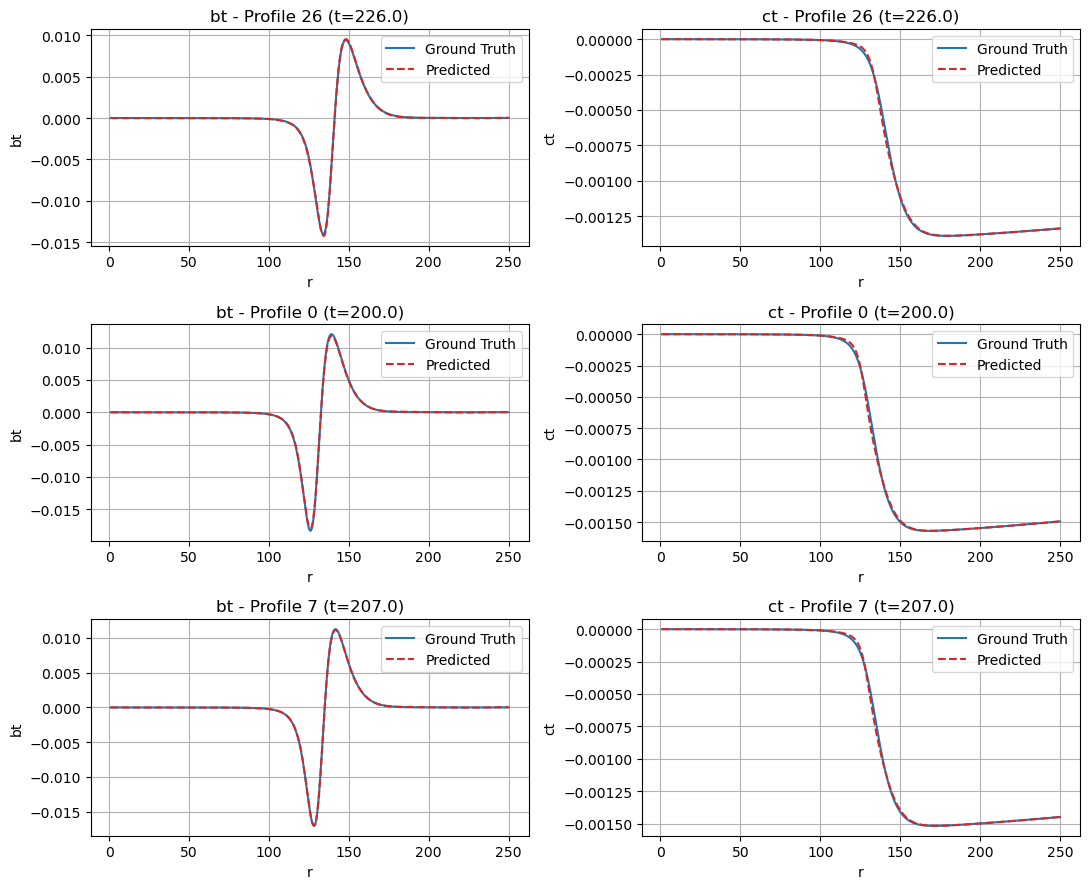

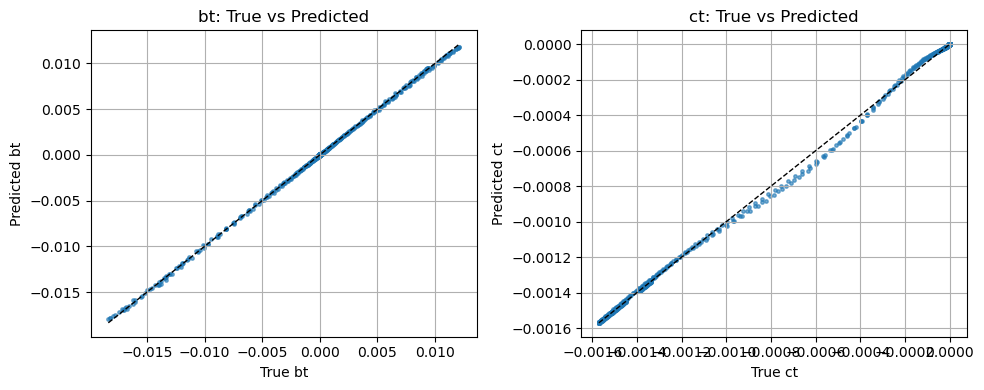

In [46]:
# compare ground truth vs predicted for a few random profiles (uses existing variables/models)
n_plots = min(3, NT1)
inds = np.random.choice(NT1, size=n_plots, replace=False)

fig, axes = plt.subplots(n_plots, 2, figsize=(11, 3*n_plots), tight_layout=True)
if n_plots == 1:
    axes = axes.reshape(1, -1)

for row, ind in enumerate(inds):
    state_temp = np.concatenate((rhs_1[0, ind, :], rhs_1[3, ind, :]))
    pred = right_hand_side(t_ar_1[ind], state_temp, r_ar_1)
    bt_pred = pred[:NR1]
    ct_pred = pred[NR1:]

    ax_b = axes[row, 0]
    ax_c = axes[row, 1]

    ax_b.plot(r_ar_1, bt_1[ind, :], c='tab:blue', label='Ground Truth')
    ax_b.plot(r_ar_1, bt_pred, c='tab:red', linestyle='--', label='Predicted')
    ax_b.set_title(f'bt - Profile {ind} (t={t_ar_1[ind]:.1f})')
    ax_b.set_xlabel('r'); ax_b.set_ylabel('bt')
    ax_b.legend(); ax_b.grid(True)

    ax_c.plot(r_ar_1, ct_1[ind, :], c='tab:blue', label='Ground Truth')
    ax_c.plot(r_ar_1, ct_pred, c='tab:red', linestyle='--', label='Predicted')
    ax_c.set_title(f'ct - Profile {ind} (t={t_ar_1[ind]:.1f})')
    ax_c.set_xlabel('r'); ax_c.set_ylabel('ct')
    ax_c.legend(); ax_c.grid(True)

# parity / scatter plots across the chosen profiles
bt_true = np.hstack([bt_1[ind, :] for ind in inds])
bt_pred_all = np.hstack([ right_hand_side(t_ar_1[ind], np.concatenate((rhs_1[0,ind,:], rhs_1[3,ind,:])), r_ar_1)[:NR1] for ind in inds])
ct_true = np.hstack([ct_1[ind, :] for ind in inds])
ct_pred_all = np.hstack([ right_hand_side(t_ar_1[ind], np.concatenate((rhs_1[0,ind,:], rhs_1[3,ind,:])), r_ar_1)[NR1:] for ind in inds])

fig, ax = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)
ax[0].scatter(bt_true, bt_pred_all, s=6, alpha=0.6)
mn, mx = np.min([bt_true.min(), bt_pred_all.min()]), np.max([bt_true.max(), bt_pred_all.max()])
ax[0].plot([mn, mx], [mn, mx], 'k--', linewidth=1)
ax[0].set_title('bt: True vs Predicted'); ax[0].set_xlabel('True bt'); ax[0].set_ylabel('Predicted bt'); ax[0].grid(True)

ax[1].scatter(ct_true, ct_pred_all, s=6, alpha=0.6)
mn, mx = np.min([ct_true.min(), ct_pred_all.min()]), np.max([ct_true.max(), ct_pred_all.max()])
ax[1].plot([mn, mx], [mn, mx], 'k--', linewidth=1)
ax[1].set_title('ct: True vs Predicted'); ax[1].set_xlabel('True ct'); ax[1].set_ylabel('Predicted ct'); ax[1].grid(True)

plt.show()

In [41]:
rhs_0.shape

(6, 1001, 2000)

In [42]:
stack_b_bx_lapb_prev.shape

(2000000, 6)

In [ ]:
Norm_in_grey = np.copy(cp_rhs)

Norm_in_mu_grey = np.mean(Norm_in_grey, axis=0) #np.zeros(6)

Norm_in_si_grey = np.std(Norm_in_grey, axis=0, ddof=1) #np.ones(6)

for i in range(6):
    Norm_in[:,i]=(cp_rhs[:,i]-Norm_in_mu_grey[i])/Norm_in_si_grey[i]
    
    
Norm_out_grey=np.copy(cp_bt)

Norm_out_mu_grey=np.mean(Norm_out_grey)

Norm_out_si_grey=np.std(Norm_out_grey, ddof=1)

Norm_out_grey=(cp_bt-Norm_out_mu_grey)/Norm_out_si_grey